In [520]:
# Q1:
import torchvision
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as func
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, RandomSampler, random_split
import matplotlib.pyplot as plt

mnist_train=torchvision.datasets.MNIST('mnist',
                train=True,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ]))

# Get validation split here (5000 random samples as validation data)
# mnist_valid = random_split(mnist_train, [len(mnist_train) - 5000, 5000])
# dataset_size = len(mnist_train)
# indices = list(range(dataset_size))
# validation_split = 0.2
# split = int(validation_split * dataset_size)
# np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

mnist_test=torchvision.datasets.MNIST('mnist',
                train=False,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ]))

print(type(mnist_train))


<class 'torchvision.datasets.mnist.MNIST'>


In [521]:
print(mnist_train.data.shape)
print(mnist_test.data.shape)
print(len(mnist_test))

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
10000


In [522]:
# Dataloader for laoding in data
# Steps to do this is to convert raw data to tensor
# Then tensor to dataset object
# And then from dataset object to dataloader

# Our MNIST is already in tensorDataset format
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
                                             batch_size=8000, 
                                             shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
                                             batch_size=len(mnist_test), 
                                             shuffle=True)
# First split trainset into train and validation data
# train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=5000, sampler=train_sampler)
# valid_loader = torch.utils.data.DataLoader(mnist_train, batch_size=len(val_indices), sampler=valid_sampler)

# Same for test dataset
# testset = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)



In [523]:
class NN(nn.Module):
    
    def __init__(self):
        super(NN, self).__init__() # any init calls before this should also call this init only
        self.fp_input = nn.Linear(28*28, 1024)
        self.fp1 = nn.Linear(1024, 1024)
        self.fp2 = nn.Linear(1024, 1024)
        self.fp3 = nn.Linear(1024, 1024)
        self.fp4 = nn.Linear(1024, 1024)
        self.fp5 = nn.Linear(1024, 1024)
        self.fp_output = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.2)
#         self.output_activation = nn.softmax(dim = 1)
        
    def forward(self, input):
        # flatten input already so that it is a row vector
        input = self.fp_input(input)
#         input = func.leaky_relu(input)
        input = func.relu(input)
#         input - self.dropout(input)
        
        input = self.fp1(input)
        input = func.relu(input)
        
        input = self.fp2(input)
        input = func.relu(input)
#         input - self.dropout(input)
        
        input = self.fp3(input)
        input = func.relu(input)
        
        input = self.fp4(input)
        input = func.relu(input)
#         input - self.dropout(input)
        
        input = self.fp5(input)
        input = func.relu(input)

        input = self.fp_output(input)
        input = func.softmax(input, dim = 1)
        return input        
    

In [524]:
#Uniform initialization      
def weights_init_uniform_rule(m):    
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)   
        
        
def xavier_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
def he_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
#         print(m.weight)
        m.bias.data.fill_(0.01)
        



In [525]:
net = None

In [526]:
# Need to set optimizers and loss functions
def create_and_run_network(lr):
    # A minor difference is that the implementation of CrossEntrypyLoss implicitly applies a softmax activation followed by a log transformation 
    # but NLLLoss does not.
    torch.cuda.is_available()
    device = torch.device('cuda')

    # Calling the NN class
    net = NN()
    net.apply(he_weights)
#     net.apply(xavier_weights)
    if torch.cuda.is_available():
        net = NN().to(device)
    
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
#     optimizer = torch.optim.SGD(net.parameters(), lr = lr)

    train_loss_all = []
    valid_loss_all = []

    max_performance = -99
    tolerance_level = 0

    epochs = 100
    for epoch in range(1, epochs):
        train_loss = 0
        valid_loss = 0

        for i, (data, labels) in enumerate(train_loader):
            data = data.reshape(-1, 784)

            # Push all variables to cuda
            if(torch.cuda.is_available()):
                data, labels =  data.to(device), labels.to(device)

            output = net(data).to(device)
            loss = loss_func(output, labels)

            optimizer.zero_grad() # reset gradients
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += loss.item()

        # Now do validation and keep track of valid loss
        with torch.no_grad():
            for i, (data, labels) in enumerate(valid_loader):
                if(torch.cuda.is_available()):
                    data, labels = data.to(device), labels.to(device)

                # FP     
                val_labels_pred = net.forward(data.reshape(-1, 784)).to(device)
                performance = accuracy_score(labels.cpu().numpy(),val_labels_pred.argmax(1).cpu().numpy())

                v_loss = loss_func(val_labels_pred, labels)
                valid_loss += v_loss.item()


        print(f'Epoch {epoch} \t\t Training loss: {train_loss/len(mnist_train)} \t\t Validation loss: {valid_loss/len(mnist_test)} \
        Validation Accuracy: {performance*100} %')

        train_loss_all.append(train_loss/len(mnist_train))
        valid_loss_all.append(valid_loss/len(mnist_test))
        
        if(performance*100 > max_performance):
            max_performance = performance*100
            tolerance_level = 0
        else:
            if(tolerance_level == 7):
                print('EARLY STOPPING ACTIVATED!! NO DECREASE IN VALID LOSS FOR PAST 5 EPOCHS')
                break
            else:
                tolerance_level += 1

# #         Early Stopping
#         if(valid_loss/len(mnist_test) - min_valid_loss < 0.0000005):
#             if(tolerance_level == 5):
#                 print('EARLY STOPPING ACTIVATED!! NO DECREASE IN VALID LOSS FOR PAST 5 EPOCHS')
#                 break
#             else:
#                 tolerance_level+=1    
#         else:
#             tolerance_level=0

#         min_valid_loss = min(min_valid_loss, valid_loss/len(mnist_test))
    
    print('Best Performance on Validation set(Same as Test data here) achived till now :', max_performance)
    return net
        

In [527]:
model_net = create_and_run_network(lr=0.001)

Epoch 1 		 Training loss: 0.00030067362785339357 		 Validation loss: 0.00022581894397735594         Validation Accuracy: 19.25 %
Epoch 2 		 Training loss: 0.00029953595797220864 		 Validation loss: 0.0002255922555923462         Validation Accuracy: 20.21 %
Epoch 3 		 Training loss: 0.0003003456155459086 		 Validation loss: 0.00022484374046325683         Validation Accuracy: 21.099999999999998 %
Epoch 4 		 Training loss: 0.00029948885838190716 		 Validation loss: 0.00022372236251831055         Validation Accuracy: 21.2 %
Epoch 5 		 Training loss: 0.00029393717447916666 		 Validation loss: 0.0002153522729873657         Validation Accuracy: 30.04 %
Epoch 6 		 Training loss: 0.00028218236366907756 		 Validation loss: 0.00020641806125640868         Validation Accuracy: 37.86 %
Epoch 7 		 Training loss: 0.00026620083252588907 		 Validation loss: 0.00019387770891189575         Validation Accuracy: 50.0 %
Epoch 8 		 Training loss: 0.0002495506525039673 		 Validation loss: 0.0001787356615066528

### Testing the accuracy on test data

In [487]:
with torch.no_grad():
    for i, (data, labels) in enumerate(valid_loader):
        if(torch.cuda.is_available()):
            data, labels = data.to(device), labels.to(device)

        # FP     
        val_labels_pred = model_net.forward(data.reshape(-1, 784)).to(device)
        performance = accuracy_score(labels.cpu().numpy(),val_labels_pred.argmax(1).cpu().numpy())

print(' Accuracy on Test dataset : ', performance*100 ,' %')

 Accuracy on Test dataset :  97.99  %


In [405]:
# torch.save(model_net, 'Model Prob1 Net')

## Problem 1.3

In [497]:
# Get the softmax layer output
with torch.no_grad():
    for i, (data, labels) in enumerate(valid_loader):
        data = data.to(device)
        softmax_output = model_net.forward(data.reshape(-1, 784)).to(device)

In [498]:
print(softmax_output.shape)

torch.Size([10000, 10])


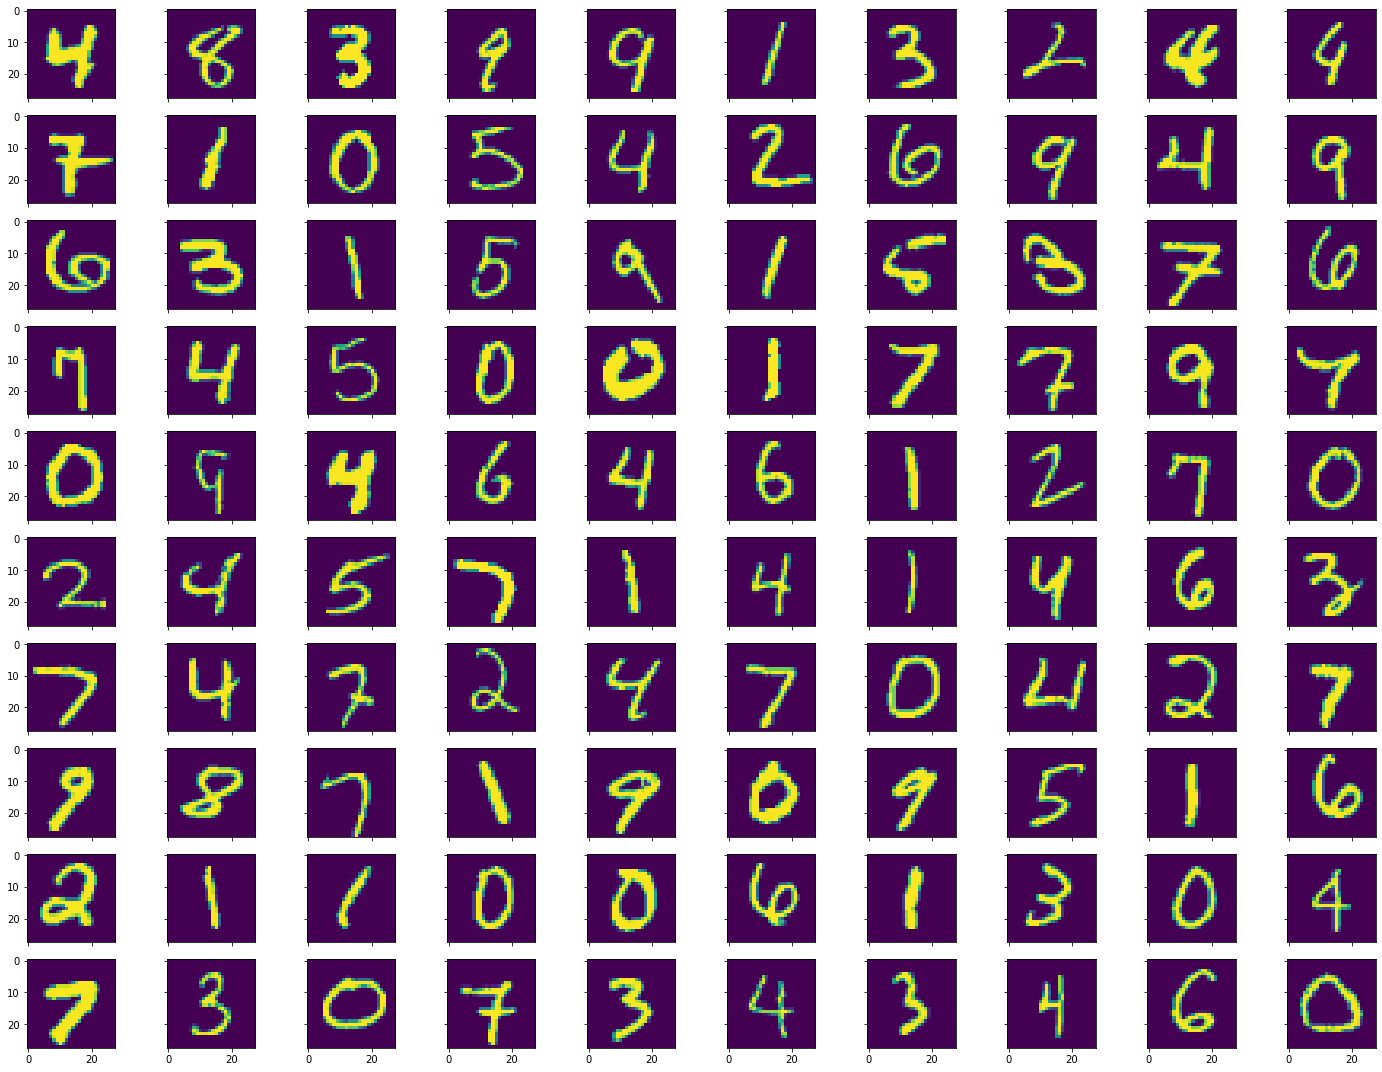

In [499]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize = (20,15) )

for i in range(10):
    # for each digit, get the top 10 data points which have hightest activations for that digit's index
    val, ind = torch.topk(softmax_output[:,i], 10)
#     print(ind)
    for j in range(len(ind)):
        ax = axes[i, j]
        ax.imshow(mnist_test[ind[j]][0][0,:,:])
plt.tight_layout()
plt.show()
    

IndexError: too many indices for tensor of dimension 1

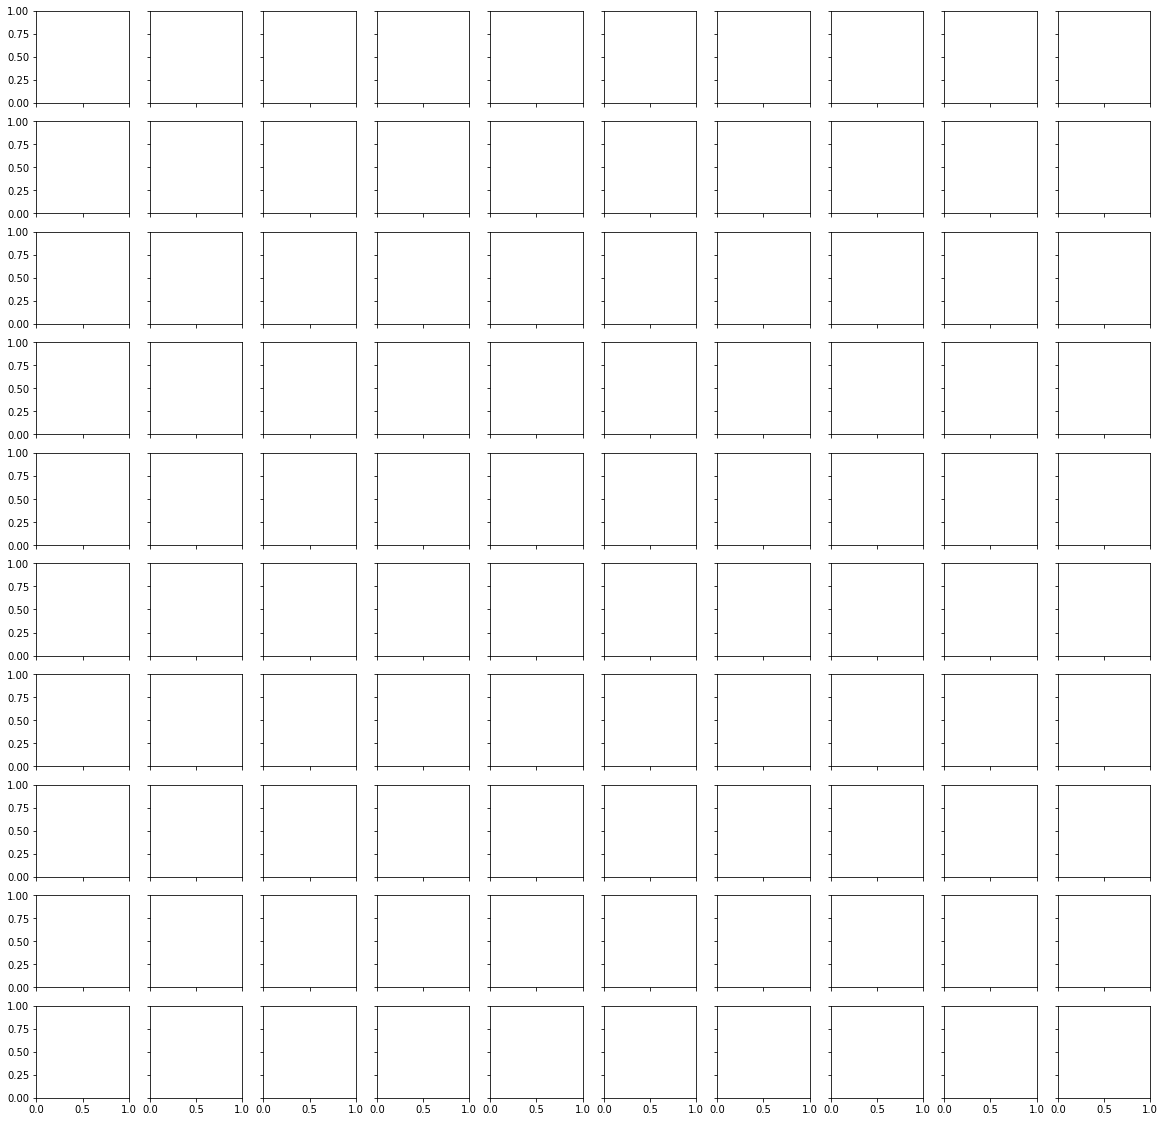

In [503]:
fig, axes = plt.subplots(10,10, 
                         figsize=(20,20),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect='equal'))
for i in range(0,10):
    val_images_curr = mnist_test.data[np.where(softmax_output==i),:,:]
    val_labels_curr = mnist_test.targets[np.where(softmax_output==i)]
    for j in range(0,10):
        ax = axes[i,j]
        # plot image on subplot
        img = val_images_curr[j]
        label = str(val_labels_curr[j].item())
        ax.imshow(img, cmap='gray_r')
        ax.set_title("P:"+str(i)+"; A:"+label)
plt.show()